# Tensorflow Testspace
### Scope
There are a few things that are really not intuitive to understand when it comes to Tensorflow.  Below are heavily commented code snippets that explain some of these that I have encountered so far.
##### Topics
* tf.cond
* tf.image.<> augmentation
* tf.placeholder_with_default

Note: notebook uses Tensorflow version 1.5.0

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### tf.cond
tf.cond is used as a conditional, and replaces if/else statements.  If/else doesn't work because of the way the graph is constructed in Tensorflow.  The graph is only made once, and the condition that is true at construction time is the condition that will be created.  Therefore, both paths need to be made, and that is what tf.cond does.

#### Usage
The Tensorflow documentation states:

``
tf.cond(
    pred,
    true_fn=None,
    false_fn=None,
    strict=False,
    name=None,
)``

and

* "Return ``true_fn()`` if the predicate pred is true else ``false_fn()``"
* "``true_fn`` and ``false_fn`` both return lists of output tensors"

This is confusing, because the first statement seems like it returns a function (and contradicts the second statement), i.e. if true, return the function in the true parameter, and then use what it returns (a function) to further do operations.  For example,

In [ ]:
# WRONG Example
def training(x):
    return x
def not_training(x):
    return 1-x

func = tf.cond(tf.equal(is_training, 1), training, lambda: not_training)
output = func(something)

This is actually not what happens at all.  The ``true_fn`` and ``false_fn`` need to be declared first as lambdas even if they are functions, and second, need to take in their input *in the tf.cond*.  Below is the working way to do it:

In [ ]:
# NON WORKING EXAMPLE
def training(x):
    return x
def not_training(x):
    return 1-x

output = tf.cond(tf.equal(is_training, 1), lambda: training(something), lambda: not_training(something))

Now let's just do a runnable example:

In [24]:
tf.reset_default_graph()
# create a placeholder with a scalar shape, i.e. []
is_training = tf.placeholder(tf.int32, [])
# create a placeholder that holds a bool
is_training_bool = tf.placeholder(tf.bool, [])
# create a placeholder to hold our input
num = tf.placeholder(tf.int32, [None])


def training(x):
    return tf.add(x, 2) # can use a tf function
def not_training(x):
    return x - 2 # can use regular stuff as well

output = tf.cond(tf.equal(is_training, 1), lambda: training(num), lambda: not_training(num))  # lambda is necessary!
output_bool = tf.cond(tf.equal(is_training_bool, True), lambda: training(num), lambda: not_training(num))

with tf.Session() as sess:
    print("Using the integer placeholder...")
    out = sess.run([output], feed_dict={num: [2], is_training: 1})
    print("'is_training' set to '1':\t\t", out)
    out = sess.run([output], feed_dict={num: [2], is_training: 0})
    print("'is_training' set to '0':\t\t", out)
    
    print("\nUsing the boolean placeholder...")
    out = sess.run([output_bool], feed_dict={num: [2], is_training_bool: True})
    print("'is_training_bool' set to 'True':\t", out)
    out = sess.run([output_bool], feed_dict={num: [2], is_training_bool: False})
    print("'is_training_bool' set to 'False':\t", out)

Using the integer placeholder...
'is_training' set to '1':		 [array([4])]
'is_training' set to '0':		 [array([0])]

Using the boolean placeholder...
'is_training_bool' set to 'True':	 [array([4])]
'is_training_bool' set to 'False':	 [array([0])]


### tf.image.<> augmentation
I'll cover random flips, random contrast, and random brightness.  The documentation for these are severly lacking.  On top of that, they only work on single images!  So this section will be in two parts: what the outcome looks like when using these functions, and then how to apply them to a batch of images.

#### Usage
The Tensorflow [documentation for random flip left/right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right) states:

``
tf.image.random_flip_left_right(
    image,
    seed=None
)``

It **only** takes a 3D image as input.  It returns a 3D image that might have been flipped (because it's random).  This is similar for [random_brightness](https://www.tensorflow.org/api_docs/python/tf/image/random_brightness) and [random_contrast](https://www.tensorflow.org/api_docs/python/tf/image/random_contrast).  First, how the images look:

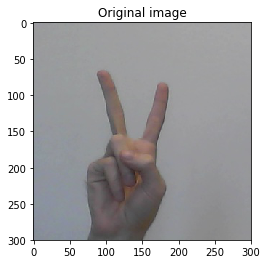

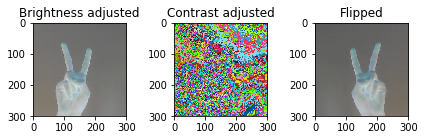

In [49]:
tf.reset_default_graph()

# read in the image
img = plt.imread('example.JPG')
plt.imshow(img)
plt.title("Original image")
plt.show()

# create a placeholder for the example image which is 300x300 with RGB channels
image = tf.placeholder(tf.float32, [300,300,3])

# place the image into random brightness
bright = tf.image.random_brightness(image, .25) # .5 = max_delta
# place the image into random contrast
contrast = tf.image.random_contrast(image, 0, .5) # lower and upper bounds on contrast
# place the image into random flip left/right
flip = tf.image.random_flip_left_right(image)

with tf.Session() as sess:
    b = sess.run([bright], feed_dict={image: img})
    c = sess.run([contrast], feed_dict={image: img})
    f = sess.run([flip], feed_dict={image: img})
    # NOTICE: above, all the outputs are coming out within arrays, so these outputs are inside arrays too.  So we
    # have to access the first position to get the image
    
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(b[0])
    ax[0].set_title("Brightness adjusted")
    ax[1].imshow(c[0])
    ax[1].set_title("Contrast adjusted")
    ax[2].imshow(f[0])
    ax[2].set_title("Flipped")
    plt.tight_layout()
    plt.show()

The contrast is really messed up...let's see what different values do...

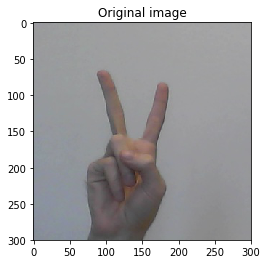

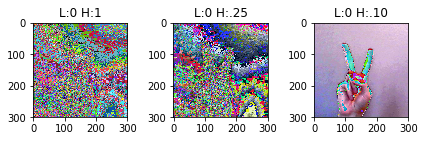

In [50]:
tf.reset_default_graph()

# read in the image
img = plt.imread('example.JPG')
plt.imshow(img)
plt.title("Original image")
plt.show()

# create a placeholder for the example image which is 300x300 with RGB channels
image = tf.placeholder(tf.float32, [300,300,3])

# place the image into random brightness and test different upper and lower bounds
contrast1 = tf.image.random_contrast(image, 0, 1) # lower and upper bounds on contrast
contrast2 = tf.image.random_contrast(image, 0, .25) # lower and upper bounds on contrast
contrast3 = tf.image.random_contrast(image, 0, .10) # lower and upper bounds on contrast

with tf.Session() as sess:
    c1 = sess.run([contrast1], feed_dict={image: img})
    c2 = sess.run([contrast2], feed_dict={image: img})
    c3 = sess.run([contrast3], feed_dict={image: img})
    # NOTICE: above, all the outputs are coming out within arrays, so these outputs are inside arrays too.  So we
    # have to access the first position to get the image
    
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(c1[0])
    ax[0].set_title("L:0 H:1")
    ax[1].imshow(c2[0])
    ax[1].set_title("L:0 H:.25")
    ax[2].imshow(c3[0])
    ax[2].set_title("L:0 H:.10")
    plt.tight_layout()
    plt.show()

Not sure how this can be helpful.  Maybe it's normal to a machine, but to human eyes it looks bad.

### tf.placeholder_with_default
tf.placeholder_with_default does exactly what it sounds like: allows a placeholder to hold a default value when nothing is specifically passed to it.  However, its format is slightly different and confused me for awhile.

#### Usage
The [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default) states:

``
tf.placeholder_with_default(
    input,
    shape,
    name=None
)
``

What's slightly confusing is the dtype, since it isn't explicitly provided.  It is inferred from the input.  It's best to just see some examples:

In [33]:
tf.reset_default_graph()

print("Placeholder_with_default datatypes...")
is_training = tf.placeholder_with_default(1, [])
print("'is_training' dtype:\t\t", is_training.dtype)
is_training_bool = tf.placeholder_with_default(True, [])  # this does not make it bool dtype for some reason...
print("'is_training_bool' dtype:\t", is_training.dtype)
array = tf.placeholder_with_default(np.array([[1,2,3,4.0]]), [1,4])  # shapes must match here!
print("'array' dtype:\t\t\t", array.dtype)

with tf.Session() as sess:
    print("\nUsing the interger placeholder with default...")
    out = sess.run([is_training], feed_dict={})
    print("'is_training' defaults to '1':\t\t\t", out)
    out = sess.run([is_training], feed_dict={is_training: 0})
    print("'is_training' set to '0':\t\t\t", out)
    
    print("\nUsing the boolean placeholder with default...")
    out = sess.run([is_training_bool], feed_dict={})
    print("'is_training_bool' defaults to 'True':\t\t", out)
    out = sess.run([is_training_bool], feed_dict={is_training_bool: False})
    print("'is_training_bool' set to 'False':\t\t", out)
    
    print("\nUsing the array placeholder with default...")
    out = sess.run([array], feed_dict={})
    print("'array' defaults to '[1,2,3,4.0]':\t\t", out)
    out = sess.run([array], feed_dict={array: np.array([[10,9,8,7]])})
    print("'array' set to '[10,9,8,7]':\t\t\t", out)

'is_training' dtype:		 <dtype: 'int32'>
'is_training_bool' dtype:	 <dtype: 'int32'>
'array' dtype:			 <dtype: 'float64'>

Using the interger placeholder with default...
'is_training' defaults to '1':			 [1]
'is_training' set to '0':			 [array(0)]

Using the boolean placeholder with default...
'is_training_bool' defaults to 'True':		 [True]
'is_training_bool' set to 'False':		 [array(False)]

Using the array placeholder with default...
'array' defaults to '[1,2,3,4.0]':		 [array([[1., 2., 3., 4.]])]
'array' set to '[10,9,8,7]':			 [array([[10.,  9.,  8.,  7.]])]


Last update: 3/7/18